In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline for compatibility with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from itertools import product

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.colheader_justify', 'left')  # Align headers properly
pd.set_option('display.max_colwidth', None)  # Don't truncate column values

In [91]:
df_2017 =  pd.read_csv('/Users/emmalim/Desktop/DSA4263/traindata_2017_v1.csv')
df_2018 =  pd.read_csv('/Users/emmalim/Desktop/DSA4263/testdata_2018_v1.csv')

# Graph Metric feature engineering

In [ ]:

def build_directed_graph_and_compute_metrics(df):
    # Step 1: Build directed graph based on Flow ID
    G = nx.DiGraph()
    flow_groups = df.groupby('Flow ID')

    for flow_id, group in flow_groups:
        src_ips = set(group['Source IP'])
        dst_ips = set(group['Destination IP'])

        for src, dst in product(src_ips, dst_ips):
            if src != dst:
                if G.has_edge(src, dst):
                    G[src][dst]['weight'] += 1
                else:
                    G.add_edge(src, dst, weight=1)

    # Step 2: Compute graph metrics (not normalized)
    weighted_degrees = dict(G.degree(weight='weight')) # total degree
    pagerank_scores = nx.pagerank(G, weight='weight')
    degree_centrality = nx.degree_centrality(G)
    core_number = nx.core_number(G.to_undirected())  # k-core only works on undirected graphs


    # Step 3: Mapping to dataframe (using raw values)
    def get_avg_graph_metrics(row):
        src = row['Source IP']
        dst = row['Destination IP']
        return pd.Series({
            'average_weighted_degree': (weighted_degrees.get(src, 0) + weighted_degrees.get(dst, 0)) / 2,
            'average_page_rank': (pagerank_scores.get(src, 0) + pagerank_scores.get(dst, 0)) / 2,
            'average_degree_centrality': (degree_centrality.get(src, 0) + degree_centrality.get(dst, 0)) / 2,
            'average_k_core': (core_number.get(src, 0) + core_number.get(dst, 0)) / 2,

        })

    df[[ 
        'average_weighted_degree', 'average_page_rank',
        'average_degree_centrality', 'average_k_core',
    ]] = df.apply(get_avg_graph_metrics, axis=1)

    return df


df_2017 = build_directed_graph_and_compute_metrics(df_2017)
df_2018 = build_directed_graph_and_compute_metrics(df_2018)


# Models

In [96]:
df_2017_final = df_2017.copy()
df_2018_final = df_2018.copy()

In [97]:
to_remove = ['Flow ID', 'Source IP', 'Destination IP', 'Destination Port','Timestamp', 'Protocol', 'Source Port'] 
df_2017_final.drop(columns=to_remove , inplace=True, errors='ignore')
df_2018_final.drop(columns=to_remove , inplace=True, errors='ignore')

In [98]:
# Separate features and target variables
X_train = df_2017_final.drop(columns=['Label'])
y_train = df_2017_final['Label']
X_test = df_2018_final.drop(columns=['Label'])
y_test = df_2018_final['Label']
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480383 entries, 0 to 480382
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow Duration                480383 non-null  int64  
 1   Total Fwd Packets            480383 non-null  int64  
 2   Total Backward Packets       480383 non-null  int64  
 3   Total Length of Fwd Packets  480383 non-null  int64  
 4   Fwd Packet Length Max        480383 non-null  int64  
 5   Fwd Packet Length Min        480383 non-null  int64  
 6   Fwd Packet Length Mean       480383 non-null  float64
 7   Bwd Packet Length Max        480383 non-null  int64  
 8   Bwd Packet Length Min        480383 non-null  int64  
 9   Flow Bytes/s                 480383 non-null  float64
 10  Flow Packets/s               480383 non-null  float64
 11  Flow IAT Mean                480383 non-null  float64
 12  Flow IAT Min                 480383 non-null  float64
 13 

### Logistic Regression 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'lr__C': 0.01, 'smote__k_neighbors': 3}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50   1343290
           1       0.39      1.00      0.56    575394

    accuracy                           0.53   1918684
   macro avg       0.70      0.67      0.53   1918684
weighted avg       0.82      0.53      0.52   1918684

Confusion Matrix:
 [[445405 897885]
 [     0 575394]]
Accuracy: 0.5320
Precision: 0.3906
Recall: 1.0000
F1 Score: 0.5617
ROC AUC Score: 0.6544

Top Feature Importances:
    Feature                       Coefficient
7         Bwd Packet Length Max  7.199212   
6        Fwd Packet Length Mean -7.184289   
43      average_weighted_degree  6.579553   
4         Fwd Packet Length Max -5.933440   
30                Down/Up Ratio -4.286712   
29               URG Flag Count -4.056052   
34         min_seg_size_forward  2.558910   


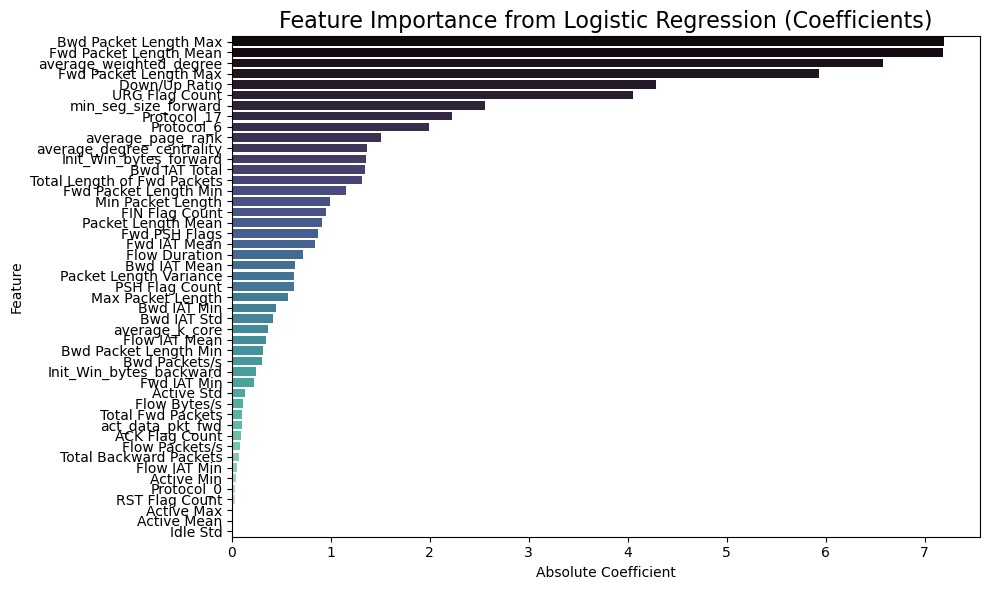

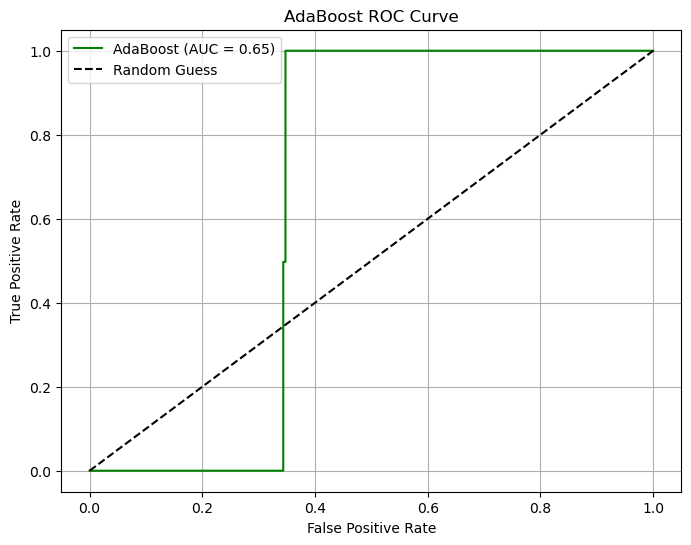

In [ ]:
from imblearn.pipeline import Pipeline

#  Define Pipeline
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

# Define Hyperparameter Grid
param_grid = {
    'lr__C': [0.01, 0.1, 1],  # Regularization strength
    'smote__k_neighbors': [3, 5, 7]  # SMOTE neighbor choices
}

# Grid Search CV
grid_search_logreg_graph = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',   
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_logreg_graph.fit(X_train, y_train)


# Best Model & Predictions
best_model_logreg_graph = grid_search_logreg_graph.best_estimator_
y_pred = best_model_logreg_graph.predict(X_test)
y_proba = best_model_logreg_graph.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search_logreg_graph.best_params_}\n")


# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


# Get feature names from the training data
feature_names = X_train.columns

# Extract coefficients
coefficients = best_model_logreg_graph.named_steps['lr'].coef_[0]

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Display the sorted importance
print("\nTop Feature Importances:\n", importance_df[['Feature', 'Coefficient']])

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df, palette='mako')
plt.title('Feature Importance from Logistic Regression (Coefficients)', fontsize=16)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("AdaBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

### AdaBoost

Fitting 5 folds for each of 6 candidates, totalling 30 fits

 Best Params: {'adaboost__estimator': DecisionTreeClassifier(class_weight={0: 1, 1: 3}, max_depth=1), 'adaboost__learning_rate': 1.5, 'adaboost__n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73   1343290
           1       0.50      0.98      0.66    575394

    accuracy                           0.70   1918684
   macro avg       0.74      0.78      0.70   1918684
weighted avg       0.84      0.70      0.71   1918684

Confusion Matrix:
 [[774407 568883]
 [  8756 566638]]
Accuracy: 0.6989
Precision: 0.4990
Recall: 0.9848
F1 Score: 0.6624
ROC AUC Score: 0.9765


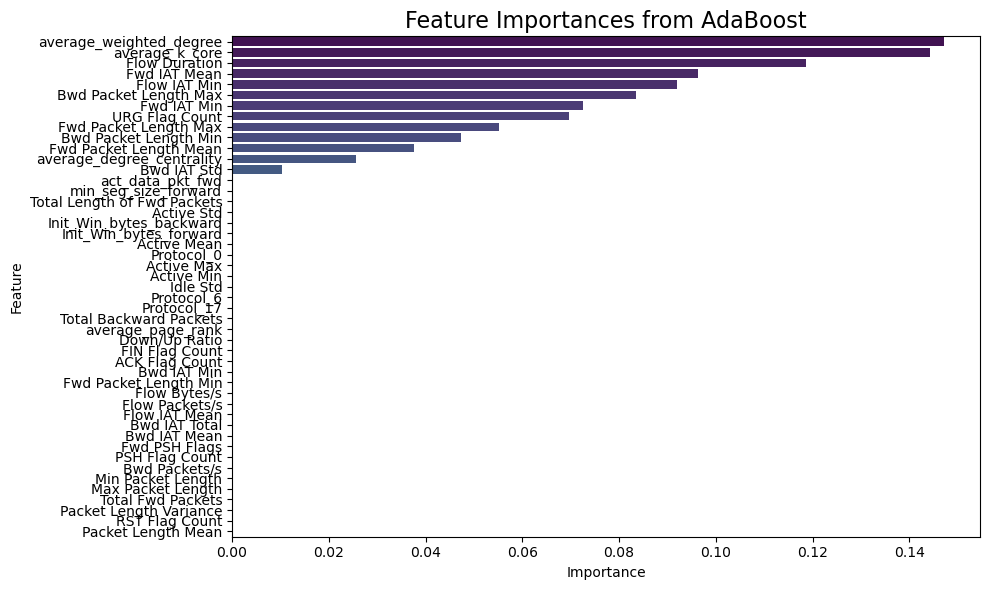

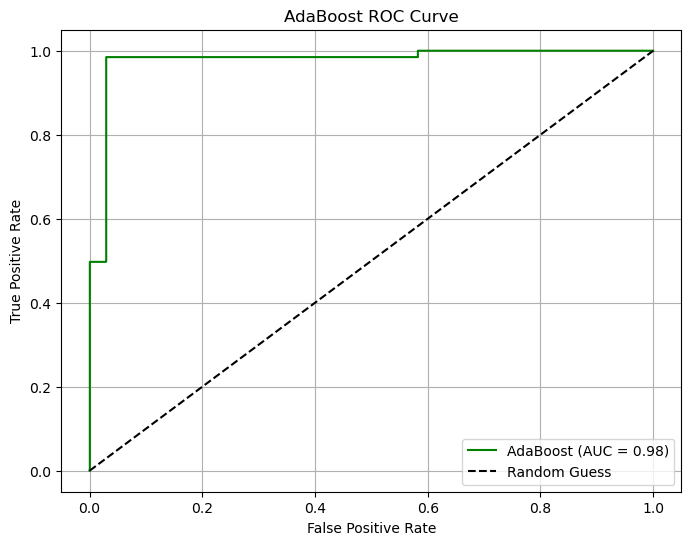

In [106]:
from sklearn.pipeline import Pipeline


# Define the pipeline steps
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('adaboost', AdaBoostClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'adaboost__n_estimators': [50,100,200],
    'adaboost__learning_rate': [1.0, 1.5],
    'adaboost__estimator': [
        DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: 3})
    ]
}

# GridSearchCV with F1 score
grid_search_ada_graph = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on 2017 training data
grid_search_ada_graph.fit(X_train, y_train)

# Best model
best_model_ada_graph = grid_search_ada_graph.best_estimator_
print(f"\n Best Params: {grid_search_ada_graph.best_params_}")


# Predict on 2018 test data
y_pred = best_model_ada_graph.predict(X_test)
y_proba = best_model_ada_graph.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

feature_names = X_train.columns
importances = best_model_ada_graph.named_steps['adaboost'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances from AdaBoost", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("AdaBoost ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### Baseline Models

In [101]:
df_2017_base = df_2017.copy()
df_2018_base = df_2018.copy()

to_remove = ['Flow ID', 'Source IP', 'Destination IP', 'Destination Port','Timestamp', 'Protocol', 'Source Port', 'average_weighted_degree', 'average_page_rank', 'average_degree_centrality', 'average_k_core',] 
df_2017_base.drop(columns=to_remove , inplace=True, errors='ignore')
df_2018_base.drop(columns=to_remove , inplace=True, errors='ignore')

# Separate features and target variables
X_train_base = df_2017_base.drop(columns=['Label'])
y_train = df_2017_base['Label']
X_test_base = df_2018_base.drop(columns=['Label'])
y_test = df_2018_base['Label']


In [102]:
#  Define Pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])


# Define Hyperparameter Grid
param_grid = {
    'lr__C': [0.01],  # Regularization strength
    'smote__k_neighbors': [5]  # SMOTE neighbor choices
}

# Grid Search CV
grid_search_logreg = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',    # Or 'roc_auc', 'precision'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_logreg.fit(X_train_base, y_train)


# Best Model & Predictions
best_model_logreg = grid_search_logreg.best_estimator_
y_pred = best_model_logreg.predict(X_test_base)
y_proba = best_model_logreg.predict_proba(X_test_base)[:, 1]

print(f"Best Parameters: {grid_search_logreg.best_params_}\n")


# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'lr__C': 0.01, 'smote__k_neighbors': 5}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87   1343290
           1       0.87      0.35      0.50    575394

    accuracy                           0.79   1918684
   macro avg       0.82      0.66      0.68   1918684
weighted avg       0.80      0.79      0.76   1918684

Confusion Matrix:
 [[1311767   31523]
 [ 372608  202786]]
Accuracy: 0.7894
Precision: 0.8655
Recall: 0.3524
F1 Score: 0.5009
ROC AUC Score: 0.7605


In [103]:
# Define AdaBoost Pipeline
adaboost_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('ada', AdaBoostClassifier(random_state=42))
])

# Define Hyperparameter Grid

adaboost_param_grid = {
    'ada__n_estimators': [100],
    'ada__learning_rate': [1.5],
}

# Grid Search CV
grid_search_ada = GridSearchCV(
    estimator=adaboost_pipeline,
    param_grid=adaboost_param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_ada.fit(X_train_base, y_train)


# Best Model & Predictions
best_model_ada = grid_search_ada.best_estimator_
y_pred_ada = best_model_ada.predict(X_test_base)
y_proba_ada = best_model_ada.predict_proba(X_test_base)[:, 1]

print(f"\n🔧 AdaBoost Best Parameters: {grid_search_ada.best_params_}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ada):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_ada):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ada):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_ada):.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits

🔧 AdaBoost Best Parameters: {'ada__learning_rate': 1.5, 'ada__n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86   1343290
           1       0.71      0.49      0.58    575394

    accuracy                           0.79   1918684
   macro avg       0.76      0.70      0.72   1918684
weighted avg       0.78      0.79      0.77   1918684

Confusion Matrix:
 [[1227940  115350]
 [ 296005  279389]]
Accuracy: 0.7856
Precision: 0.7078
Recall: 0.4856
F1 Score: 0.5760
ROC AUC Score: 0.8125


### Ensemble Log Reg and ADAboost

In [ ]:
# Get predicted probabilities (probability of class 1)
proba_logreg = best_model_logreg.predict_proba(X_test_base)[:, 1]
proba_adaboost = best_model_ada.predict_proba(X_test_base)[:, 1]
proba_logreg_graph = best_model_logreg_graph.predict_proba(X_test)[:, 1]
proba_adaboost_graph = best_model_ada_graph.predict_proba(X_test)[:, 1]

# Average the probabilities (soft voting)
avg_proba = (proba_logreg + proba_adaboost + proba_logreg_graph + proba_adaboost_graph) / 4

# Convert probabilities to final predictions
threshold = 0.5 
y_pred_ensemble = (avg_proba >= threshold).astype(int)

# Evaluate
print("Classification Report (Ensemble):")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))

accuracy = np.mean(y_pred_ensemble == y_test)
precision = np.sum((y_pred_ensemble == 1) & (y_test == 1)) / np.sum(y_pred_ensemble == 1)
recall = np.sum((y_pred_ensemble == 1) & (y_test == 1)) / np.sum(y_test == 1)
f1 = 2 * (precision * recall) / (precision + recall)
roc_auc = roc_auc_score(y_test, avg_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.99      0.88      0.93   1343290
           1       0.78      0.98      0.87    575394

    accuracy                           0.91   1918684
   macro avg       0.89      0.93      0.90   1918684
weighted avg       0.93      0.91      0.91   1918684

Confusion Matrix:
[[1182410  160880]
 [   8758  566636]]
Accuracy: 0.9116
Precision: 0.7789
Recall: 0.9848
F1 Score: 0.8698
ROC AUC Score: 0.9453


# PCA plot on graph metrics

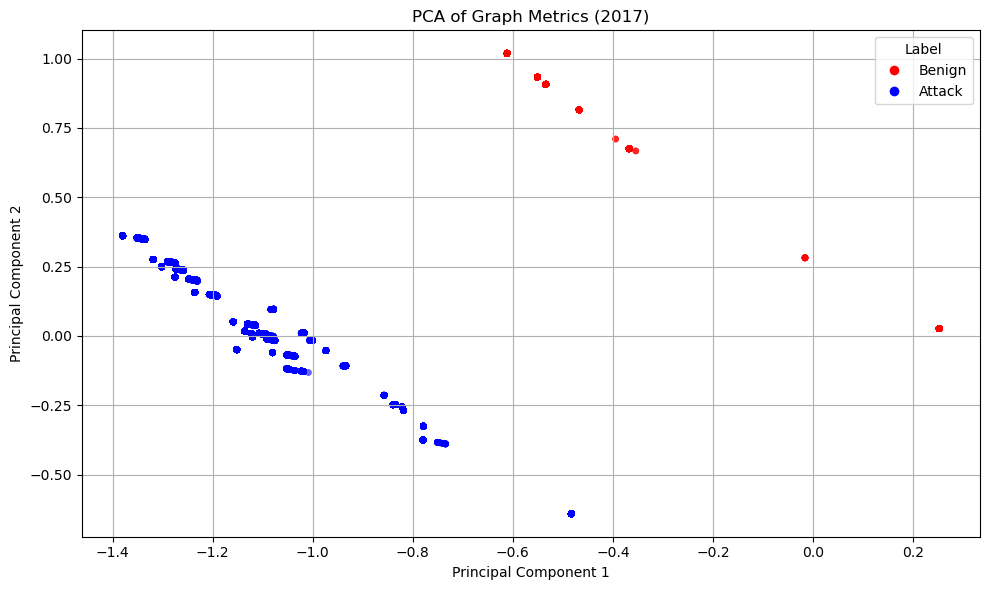

In [110]:
selected_cols = [
    'average_weighted_degree', 'average_page_rank',
        'average_degree_centrality', 'average_k_core',
         'Label'
]

df_2017_analysis = df_2017_final[selected_cols]
X = df_2017_analysis[selected_cols]
y = df_2017_analysis['Label']  # 0 = benign, 1 = attack


# Standardize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y,
    palette={0: 'blue', 1: 'red'}, alpha=0.6, s=20, edgecolor=None
)

custom_lines = [
    Line2D([0], [0], marker='o', color='w', label='Benign',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Attack',
           markerfacecolor='blue', markersize=8)
]

plt.legend(handles=custom_lines, title="Label")
plt.title('PCA of Graph Metrics (2017)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

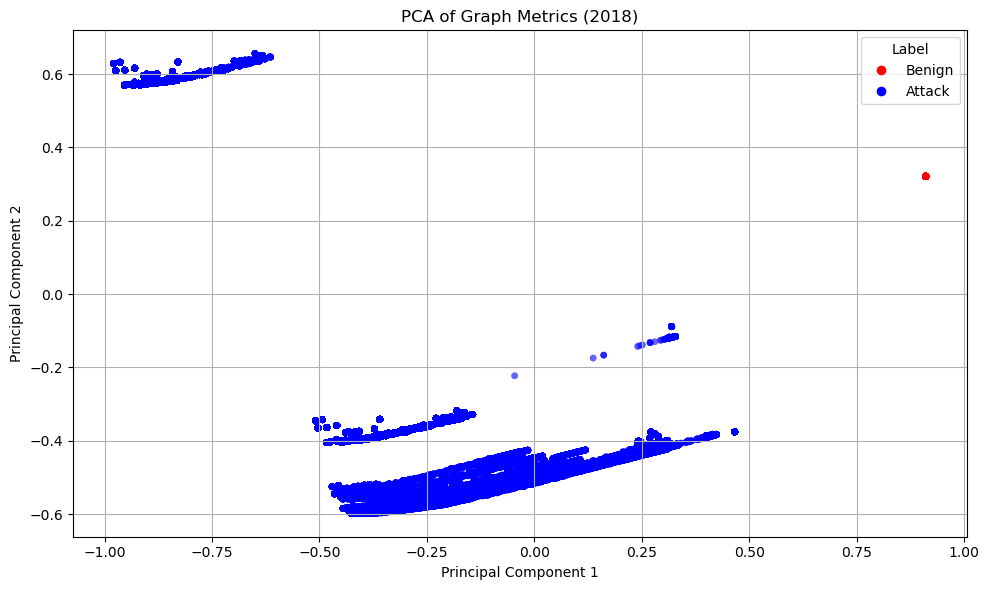

In [109]:
selected_cols = [
    'average_weighted_degree', 'average_page_rank',
        'average_degree_centrality', 'average_k_core',
         'Label'
]

df_2017_analysis = df_2018_final[selected_cols]
X = df_2017_analysis[selected_cols]
y = df_2017_analysis['Label']  # 0 = benign, 1 = attack


# Standardize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y,
    palette={0: 'blue', 1: 'red'}, alpha=0.6, s=20, edgecolor=None
)

custom_lines = [
    Line2D([0], [0], marker='o', color='w', label='Benign',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Attack',
           markerfacecolor='blue', markersize=8)
]

plt.legend(handles=custom_lines, title="Label")
plt.title('PCA of Graph Metrics (2018)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()
